Test Code to demonstrate the use of the video proc algorithm

In [ ]:
from src import hrNetVideo, lpipsClass, readFrames
import numpy as np
import matplotlib.pyplot as plt
# TO-DO: write/improve descriptions for classes and functions (not important, but helps with understanding code later on)

To process a video, add the video properties down below

In [ ]:
vidFileName = 'KristenAndSara_10frames_512x256.yuv420p'
# Note the Kristen video has a length of 7 frames
vidResolution = (512,256)
vidNumFrames = 7

Create an instance of the video restoration model using the video properties. The video restoration model allows
for the restoration of one frame (using the restore_frame() function) or an entire video (restore_video() function)

In [ ]:
hrNetVideoModel = hrNetVideo(vidFileName,vidResolution,vidNumFrames)

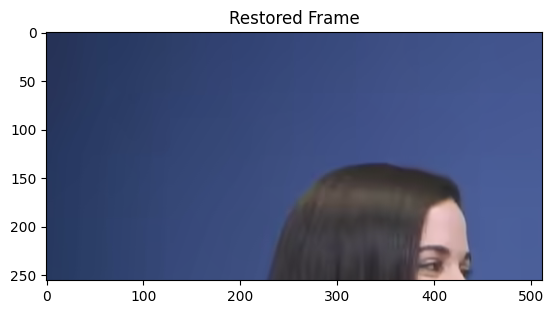

In [4]:
# Takes about 10 min to run for a 1080p video on my laptop
restoredFrame = hrNetVideoModel.restore_frame(t=1)
plt.imshow(restoredFrame/255.0)
plt.title("Restored Frame")
plt.show()
plt.imsave("output/restoredFrame.png",restoredFrame/255.0)

In [5]:
# Produces an array of restored videos
#restoredVideo = hrNetVideoModel.restore_video()

In [6]:
#plt.imshow(restoredVideo[1]/255)
#plt.title("Restored Frame (selected from restored video array)")
#plt.show()

LPIPS is a full-reference metric, and such the frame of a reference video is also selected

(256, 512, 3)


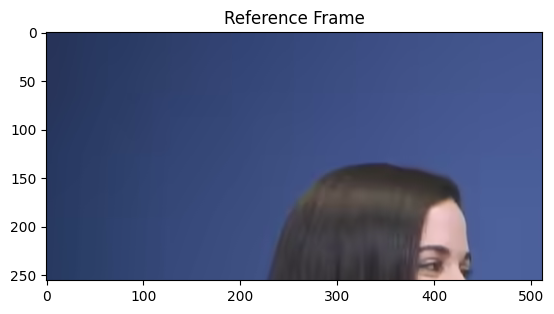

In [7]:
vidFileName = 'KristenAndSara_10frames_512x256.yuv420p'
_,refFrame,_ = readFrames(vidFileName,vidResolution,1,vidNumFrames)
print(refFrame.shape)
plt.imshow(refFrame/255.0)
plt.imsave("output/referenceFrame.png",refFrame/255.0)
plt.title("Reference Frame")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


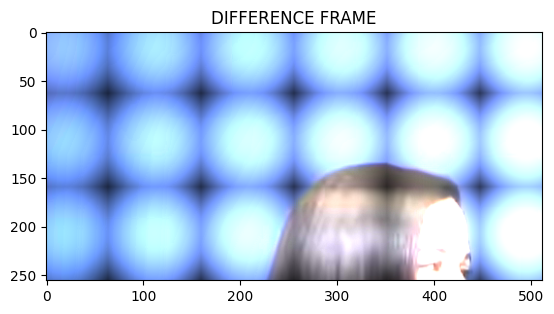

In [8]:
# Calculating the difference frame
difference_frame = np.absolute(np.subtract(restoredFrame,refFrame))
plt.imshow(difference_frame)
plt.title("DIFFERENCE FRAME")
plt.show()

Creates an instance of LPIPS, which compares two frames

In [9]:
lpipsInstance = lpipsClass()

c:\Users\victo\anaconda3\envs\hrNet\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\victo\anaconda3\envs\hrNet\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\victo\anaconda3\envs\hrNet\lib\site-packages\lpips\weights\v0.1\vgg.pth


In [10]:
#Outputs the LPIPS metric evaluation for the original frame t and the restored frame (the two inputs)
dist = lpipsInstance.computeLpipsFrame(original_frame=refFrame,restored_frame=restoredFrame)
print(dist.item())

c:\Users\victo\OneDrive\Documents\GitHub\MAIProject\src\lpipsFunctions.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x), torch.tensor(y)


0.0006471296073868871
